## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl
from sklearn.utils import class_weight

import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Reshape
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, accuracy_score
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
110482,00030080_000.png,No Finding,0,30080,47,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030080_000.png
110850,00030218_000.png,Infiltration,0,30218,49,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030218_000.png
79448,00019518_000.png,No Finding,0,19518,69,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_009/images/00019518_000.png


In [3]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia']
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
97129,00025623_005.png,Atelectasis,5,25623,48,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34874,00009215_001.png,No Finding,1,9215,40,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
60788,00015013_002.png,Cardiomegaly,2,15013,45,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create your training and testing data:

In [4]:
def create_splits(df, test_size, column_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_df, valid_df = skl.train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df[column_name])
    ## making equal proportions of Pneumonia in both sets!
    # traing data
    p_inds = train_df[train_df[column_name] == 1].index.tolist()
    np_inds = train_df[train_df[column_name] ==0].index.tolist()
    
    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    
    # validation data
    p_inds = valid_df[valid_df[column_name]==1].index.tolist()
    np_inds = valid_df[valid_df[column_name]==0].index.tolist()

    np_sample = sample(np_inds,4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    return train_df, valid_df
train_df, valid_df = create_splits(all_xray_df, 0.2, 'pneumonia_class')

In [5]:
train_df['pneumonia_class'].sum()/len(train_df)

0.5

In [6]:
valid_df['pneumonia_class'].sum()/len(valid_df)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    return my_idg


def make_train_gen(train_df, img_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    idg = my_image_augmentation()        
    train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                             directory=None, 
                                             x_col = "path",
                                             y_col = "pneumonia_class",
                                             class_mode = 'raw',
                                             target_size = img_size, 
                                             batch_size = batch_size
                                             )
    return train_gen


def make_val_gen(valid_df, img_size, batch_size):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_idg = ImageDataGenerator(rescale=1./255.)
    val_gen = val_idg.flow_from_dataframe(dataframe = valid_df, 
                                             directory=None, 
                                             x_col = "path",
                                             y_col = "pneumonia_class",
                                             class_mode = 'raw',
                                             target_size = img_size, 
                                             batch_size = batch_size) 
    return val_gen
batch_size = 64
img_size = (224, 224)

train_gen = make_train_gen(train_df, img_size, batch_size)
val_gen = make_val_gen(valid_df, img_size, batch_size)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

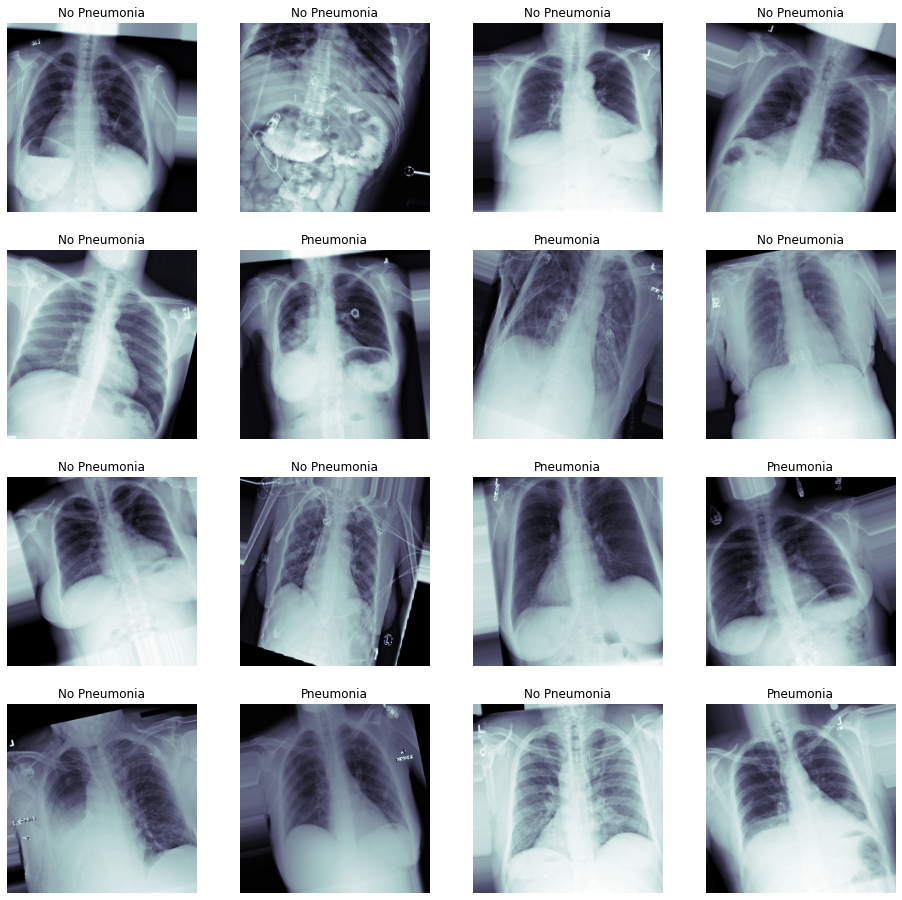

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    '''
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    '''
    model = ResNet50V2(include_top=False, weights='imagenet')
    resnet_model =  Model(inputs=model.input, outputs=model.output, name='Resnet')
    return resnet_model

In [11]:
def build_my_model():
    '''
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()
    vgg_model = load_pretrained_model()
    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1, activation='sigmoid'))
    '''
    resnet_model = load_pretrained_model()
    my_model = Sequential([resnet_model,
                        BatchNormalization(),
                        Conv2D(1024, 1, activation='relu'),
                        Dropout(0.5),
                        BatchNormalization(),
                        Conv2D(256, 1, activation='relu'),
                        Dropout(0.5),                        
                        AveragePooling2D((7,7)),
                        BatchNormalization(),
                        Conv2D(1, 1, activation='sigmoid'),
                        Reshape((-1,))
                       ])
    return my_model

my_model = build_my_model()
my_model.summary()

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Resnet (Model)               (None, None, None, 2048)  23564800  
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 2048)  8192      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 1024)  2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 1024)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 1024)  4096      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 256)   262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 256)  

In [12]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_binary_accuracy", 
                      mode= "auto", 
                      patience=5)

def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, early, lr_scheduler]

In [13]:
from keras.models import model_from_json
model_path = "best_model1.json" #path to saved model
weight_path = "xray_class_best_model.best.hdf5" #path to saved best weights

json_file = open(model_path, "r")
loaded_model_json = json_file.read()
json_file.close()
my_model = model_from_json(loaded_model_json)
my_model.load_weights(weight_path)

In [14]:
import multiprocessing as mp
cpu_count = mp.cpu_count()
cpu_count

1

### Start training! 

In [ ]:
## train your model

# Todo
optimizer = RMSprop(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY),
                          epochs = 1, 
                          callbacks = callbacks_list)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [15]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 64, verbose = True)

64/64 [==============================] - 19s 302ms/step


In [24]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr, tpr, threshold = roc_curve(valY, pred_Y)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Plot AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return

## what other performance statistics do you want to include here besides AUC? 
def plot_prec_rec(val_Y, pred_Y):
    prec, rec, threshold = precision_recall_curve(val_Y, pred_Y)
    plt.title('Plot Precision Recall')
    plt.plot(prec, rec, 'b', label = 'score = %0.2f' % average_precision_score(val_Y,pred_Y))
    plt.legend(loc = 'upper right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()


def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    n = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(n), history.history["loss"], label="train_loss")
    plt.plot(np.arange(n), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    return

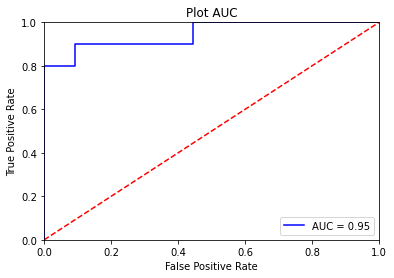

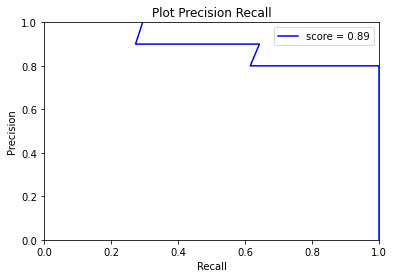

In [17]:
## plot figures

# Todo
plot_auc(valY, pred_Y)
plot_prec_rec(valY, pred_Y)
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [18]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
def optimize_accuracy(t_y, p_y):
    best_threshold = None
    best_accuracy = 0.
    for t in np.arange(0.5,1,0.001):
        pred = (p_y.reshape(-1)>t)*1.
        accuracy = np.mean(pred==t_y)
        if accuracy > best_accuracy:
            best_threshold = t
            best_accuracy = accuracy
    return best_threshold, best_accuracy
best_threshold, best_accuracy = optimize_accuracy(valY, pred_Y)
print("Threshold of %.2f gives best accuracy at %.4f"%(best_threshold, best_accuracy))
pred_Y_class = pred_Y > best_threshold
f1_score(valY, pred_Y_class)

Threshold of 1.00 gives best accuracy at 0.9688


0.888888888888889

In [25]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

precision_value = 0.8
idx1 = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx1]))
print('Recall is: '+ str(recall[idx1]))
print('Threshold is: '+ str(thresholds[idx1]))
print('F1 Score is: ' + str(calc_f1(precision[idx1],recall[idx1])))
thresh1 = thresholds[idx1]

recall_value = 0.8
idx2 = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx2]))
print('Recall is: '+ str(recall[idx2]))
print('Threshold is: '+ str(thresholds[idx2]))
print('F1 Score is: ' + str(calc_f1(precision[idx2],recall[idx2])))
thresh2 = thresholds[idx2]

Precision is: 0.8
Recall is: 0.8
Threshold is: 0.568585
F1 Score is: 0.8000000000000002
Precision is: 0.6153846153846154
Recall is: 0.8
Threshold is: 0.052553743
F1 Score is: 0.6956521739130435


In [27]:
acc = accuracy_score(valY, np.round(pred_Y))*100
cm = confusion_matrix(valY, np.round(pred_Y), labels=[1,0])
tn, fp, fn, tp = cm.ravel()
print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

CONFUSION MATRIX ------------------
[[ 8  2]
 [ 2 52]]

TEST METRICS ----------------------
Accuracy: 93.75%
Precision: 96.29629629629629%
Recall: 96.29629629629629%
F1-score: 96.29629629629629


In [19]:
%%capture
test_idg = ImageDataGenerator(rescale=1. / 255.0)
test_gen = test_idg.flow_from_dataframe(dataframe = valid_df, 
                                         directory=None, 
                                         x_col = "path",
                                         y_col = "pneumonia_class",
                                         class_mode = 'raw',
                                         target_size = img_size, 
                                         batch_size = 1) 
testX, testY = test_gen.next()
ans = [0]*1430
for i in range(1430):
    if my_model.predict(testX, batch_size = 1, verbose = True) > best_threshold:
        ans[i] = 1

In [20]:
valid_df['algorithm_output'] = ans
valid_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,algorithm_output
44636,00011472_001.png,Pneumonia,1,11472,23,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
41962,00010805_047.png,Atelectasis|Consolidation|Edema|Infiltration|P...,47,10805,9,F,AP,2048,2500,0.168000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
65834,00016258_002.png,Edema|Effusion|Pneumonia,2,16258,61,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
16260,00004342_054.png,Cardiomegaly|Edema|Effusion|Pneumonia,54,4342,48,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
59204,00014647_005.png,Pneumonia,5,14647,41,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52778,00013310_011.png,Consolidation,11,13310,58,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
96490,00025408_000.png,No Finding,0,25408,64,F,PA,2544,3056,0.139000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
107758,00029128_000.png,No Finding,0,29128,22,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
37237,00009830_000.png,No Finding,0,9830,26,F,PA,2622,2697,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
for i in ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']:

    tn, fp, fn, tp = confusion_matrix(valid_df[valid_df[i]==1].Pneumonia.values,valid_df[valid_df[i]==1].algorithm_output.values,labels=[1,0]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(i)
    print('Sensitivity: '+ str(sens))
    print('Specificity: ' +str(spec))
    print()

Atelectasis
Sensitivity: 1.0
Specificity: 0.0

Cardiomegaly
Sensitivity: 1.0
Specificity: 0.0

Consolidation
Sensitivity: 1.0
Specificity: 0.0

Edema
Sensitivity: 1.0
Specificity: 0.0

Effusion
Sensitivity: 1.0
Specificity: 0.0

Emphysema
Sensitivity: 1.0
Specificity: 0.0

Fibrosis
Sensitivity: 1.0
Specificity: 0.0

Hernia
Sensitivity: 1.0
Specificity: nan

Infiltration
Sensitivity: 1.0
Specificity: 0.0

Mass
Sensitivity: 1.0
Specificity: 0.0

No Finding
Sensitivity: 1.0
Specificity: nan

Nodule
Sensitivity: 1.0
Specificity: 0.0

Pleural_Thickening
Sensitivity: 1.0
Specificity: 0.0

Pneumothorax
Sensitivity: 1.0
Specificity: 0.0



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


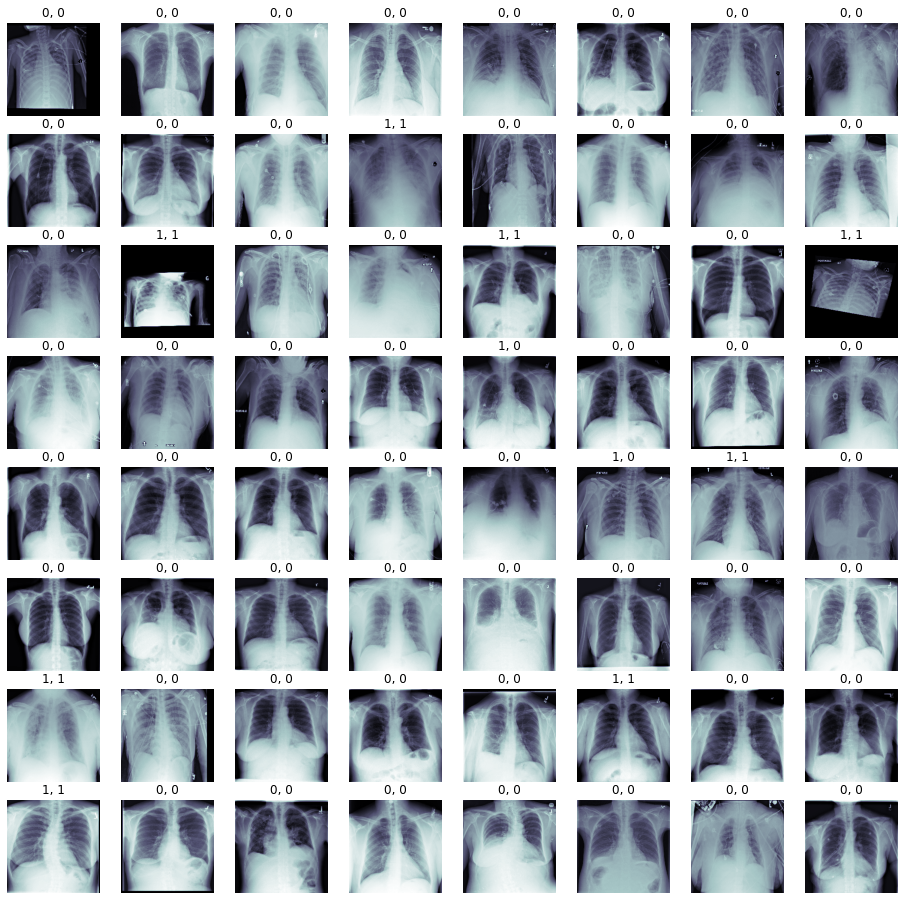

In [22]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo
YOUR_THRESHOLD = best_threshold
fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:64], valY[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)